# Interactions-based Method for Explanation (IME, Shapley Value)
Yang Xi <br>
28 Sep, 2020

<br>

* Introduction
* Cooperative (Coalitional) Game Theory
* Shapley Value
* Sub-Sampling
* Pros and Cons
* Example - Gradient Boosting Decision Tree (GBDT)
	* Model Training and Interpretation
	* GBDT Variable Importance
	* Partial Dependency Plot (PDP)
	* SHAP Value Plot
	* SHAP Dependence Plot
	* Individual SHAP Value Plot - Local Interpretability
* References

<br>


## Introduction

When a model gives a prediction for an observation, some features may have a lot of influence, while others may be irrelevant. Consequently, the effect of each feature can be measured by checking what the prediction would have been if that feature was absent.

However, observing only a single feature at a time implies that interaction between features are not taken into account. Therefore, we should observe **how the prediction changes for each possible subset of features**, and then combine these changes to form a unique contribution for each feature value.


**IME (Shapley Value)** is based on the idea:
* The feature values of an instance work together to cause a change in the model’s prediction, and
* It divides this total change in prediction among the features in a way that is “fair” to their contributions across all possible subsets of features.




## Cooperative (Coalitional) Game Theory

A **cooperative (or coalitional) game** is a tuple $(\{1,...,p\},v)$, where
* ${1,...,p}$ is a finite set of $p$ players (features)
    * set of all players is called **grand coalition**
    * subsets of players $S$ are called **coalitions**
* $v$ is a **characteristic function** such that $v(\varnothing)=0$, which describes the worth of each coalition.
* $\phi=(\phi_1,\phi_2,...,\phi_p)$ is a vector of **payoffs**.
    * We usually assume that the grand coalition forms.
    * There are infinite ways to its worth ($v$) among the players.
    * The **goal** is to find a solution $\phi$ in which the worth is split in a **fair** way.

Four properties defines the **fairness of $\phi$**:

**1. Efficiency (local accuracy)**
$$\phi_1(v)+\phi_2(v)+...+\phi_p(v)=v({1,...,p})$$

**2. Symmetry**<br>
If for two players $i$ and $j$, $v(S\cup{i})=v(S\cup{j})$ holds for every $S$, where $i,j\notin S$, then $\phi_i(v)=\phi_j(v)$

**3. Dummy**<br>
If $v(S\cup{i})=v(S)$ holds for every $S$, where $i\notin S$, then $\phi_i(v)=0$

**4. Additivity**<br>
For any pair of games $v,w:\phi(v+w)=\phi(v)+\phi(w)$, where $(v+w)(S)=v(S)+w(S)$


## Shapley Value
The **Shapley Value** is the only distribution with the above four properties. There is also an equivalent formulafor Shapley value.

Let
* $X=X_1\times X_2\times...\times X_p$: feature space of $p$ features.
* $f$: the model being explained.
* $x=(x_1,...,x_p)\in X$: the instance of interest
* $S$: a subset of feature values

$\Delta^x(S)$ is the **prediction difference** (change in the model's prediction) of a subset of feature values in a particular instance:

$$\Delta^x(S)=E[f(X_1,...,X_p)|X_{i1}=x_{i1},...,X_{iS}=x_{iS}]-E[f(X_1,...,X_p)]$$

The **cooperative game** is formed as $(\{1,...,p\},\Delta^x)$, where $\Delta^x$ is the **characteristic function**.

<br>

Let's illustrate further how IME aligns with properties of fairness:

**1. Efficiency (local accuracy)**<br>
In an instance's explanation, the sum of all $p$ contributions equals to the difference between the model's prediction and the model's expected output given no information about the instance's feature values. This property makes contributions easier to **compare across observations and models**.

**2. Symmetry**<br>
If two features an identical influence on prediction, they are assigned with identical contributions.

**3. Dummy**<br>
A feature is assigned a contribution of 0 if it has no influence.

<br>

**Notes**:
* Both the magnitude and the sign of the contributions are important.
* With the **Efficiency** property, we can discern
    * How much the model's output changes due to the specific feature values for the observation.
    * Which features are responsible for this change
    * Magnitude of influence of each feature

## Sub-Sampling

The main challenge of IME is the **exponential time complexity** to compute contibutions of all possible subsets of features.

A efficient sampling procedure is used to approximate feature contributions by perturbing the instance's input features.



## Pros and Cons
### Pros
* Provide a **uniform approach** to decompose a model's predictions into contributions that can be attributed additively to different features. It unifies different approaches like DeepLIFT, LWRP and LIME.
* Efficient implementation for tree-based models.
* Does not affect by ordering of features.

### Cons
* **Additive contributions of features** can be misleading if the model is not additive.
* Time-consuming for large models -  can be addressed by sub-sampling.


## Example - Gradient Boosting Decision Tree (GBDT)

In [1]:
import numpy as np
np.random.seed(1)
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier

dfTrain0 = pd.read_csv("../../data/(2016 UCI) Credit Default/data_train.csv")

def prepTrainTest(df):
    df = pd.get_dummies(df, columns=['Sex', 'Marriage'], drop_first=True)
    df = pd.get_dummies(df, columns=['Education', 'SepRepayment']).drop(['Education_high school', 'SepRepayment_paid'], axis=1)
    df['Default'] = df['Default']==1
    return df
dfTrain = prepTrainTest(dfTrain0)
XTrain = dfTrain.drop('Default',axis=1)

yTrain = dfTrain['Default']


### Model Training and Interpretation

In [2]:
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

gbdt = GradientBoostingClassifier(n_estimators=2000, max_depth=2, learning_rate=0.01,random_state=10)

w = (yTrain==False).sum()/(yTrain==True).sum()
sample_weights = [w if y0==True else 1 for y0 in yTrain]

gbdtFit = gbdt.fit(XTrain, yTrain, sample_weights)

# Summarize train set performance
probTrain = [x[1] for x in gbdtFit.predict_proba(XTrain)]
predTrain = gbdtFit.predict(XTrain)

cmTrain = pd.DataFrame(confusion_matrix(yTrain, predTrain))
cmTrain.columns = pd.Series(cmTrain.columns).apply(lambda s: 'pred'+str(s))
cmTrain.index = pd.Series(cmTrain.index).apply(lambda s: 'actual'+str(s))
print(cmTrain)

perfTrain = pd.DataFrame({'F1':[round(f1_score(yTrain, predTrain), 3)],
                          'AUC':[round(roc_auc_score(yTrain, probTrain),3)]})
print(perfTrain)

         pred0  pred1
actual0  14620   3500
actual1   1954   3258
      F1    AUC
0  0.544  0.788


### GBDT Variable Importance

In [3]:
gbdtVarImp = pd.DataFrame(gbdtFit.feature_importances_,
                        index=XTrain.columns, columns=['importance']).sort_values('importance', ascending=False)
print(gbdtVarImp)

                        importance
SepRepayment_2m+ delay    0.557043
SepRepayment_1m delay     0.120536
CreditLimit               0.090686
SepPay                    0.078429
AugPay                    0.064826
SepBill                   0.035419
AugBill                   0.035004
Age                       0.008267
Marriage_single           0.004976
Sex_M                     0.003069
Education_graduate        0.001288
Education_university      0.000456


### Partial Dependency Plot (PDP)
PDP shows the marginal effect one or two features have on the prediceted outcome. It can tell whether the relationship between the target and a feature is linear, monotonic or more complex.

Text(0.5, 0.98, 'Partial dependency plots of features on Default')

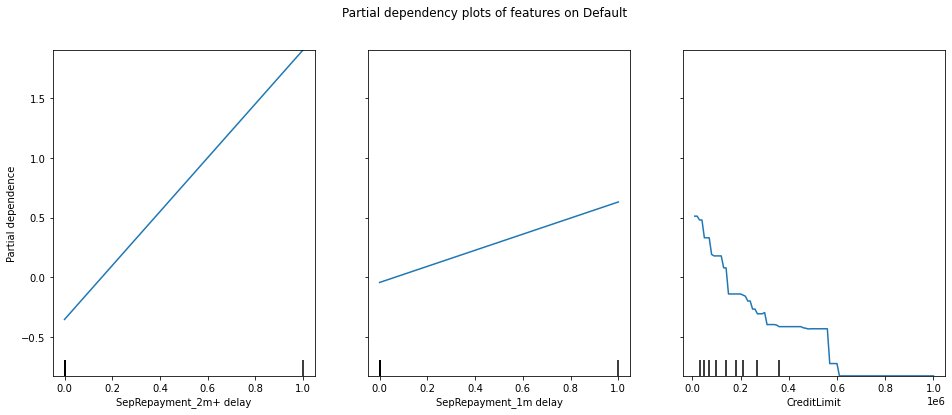

In [4]:
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt
%matplotlib inline

plot_partial_dependence(gbdtFit, XTrain, ['SepRepayment_2m+ delay', 'SepRepayment_1m delay', 'CreditLimit'])
fig = plt.gcf()
fig.set_size_inches(16,6)
fig.suptitle('Partial dependency plots of features on Default')

### SHAP Value Plot
The SHAP Value Plot is the variable importance plot generated with Shapley Values - see how it is comparable to the variable importance of GBDT!

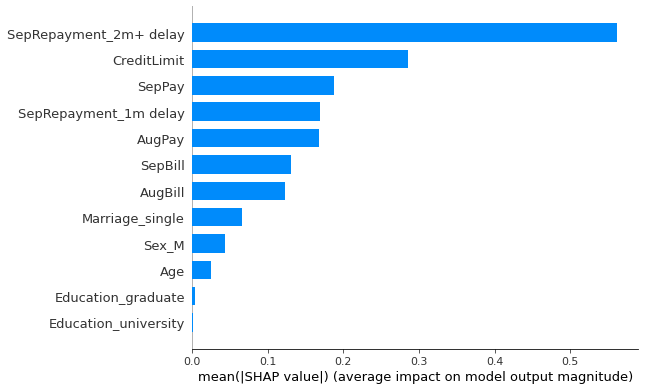

In [5]:
from shap import TreeExplainer
from shap import summary_plot

explainer = TreeExplainer(gbdtFit)
shap_values = explainer.shap_values(XTrain)
summary_plot(shap_values, XTrain, plot_type='bar')

The SHAP value plot can **show additional information**, with variables ranked in descending order of feature importance:

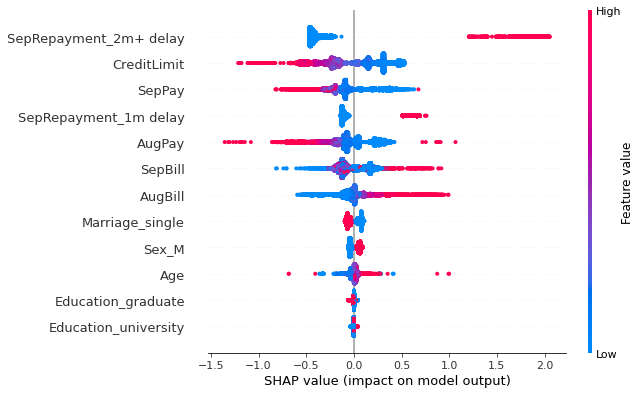

In [6]:
summary_plot(shap_values, XTrain)

### SHAP Dependence Plot

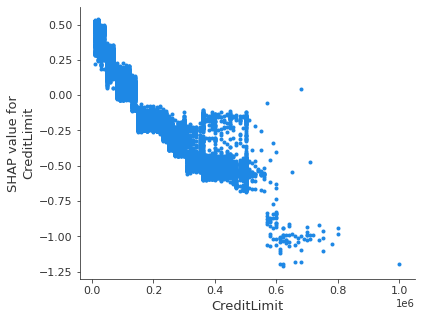

In [7]:
from shap import dependence_plot

dependence_plot('CreditLimit', shap_values, XTrain, interaction_index=None)

By default, the `dependence_plot` function automatically includes another variable that your chosen variable interacts most with.

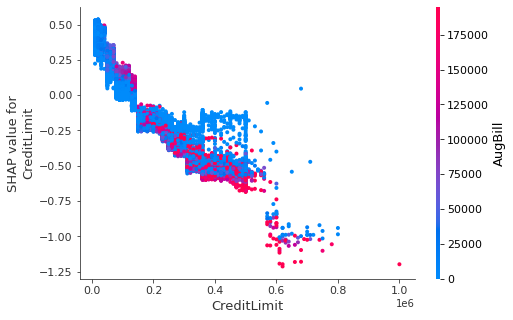

In [8]:
dependence_plot('CreditLimit', shap_values, XTrain)

### Individual SHAP Value Plot - Local Interpretability

In [9]:
from shap import initjs
initjs()


In [10]:
i = 0 

dfTrain.iloc[i]

CreditLimit               20000
Age                          24
SepBill                    3913
AugBill                    3102
SepPay                        0
AugPay                      689
Default                    True
Sex_M                         0
Marriage_single               0
Education_graduate            0
Education_university          1
SepRepayment_1m delay         0
SepRepayment_2m+ delay        1
Name: 0, dtype: object

In [11]:
probTrain[i]

0.9280180572470419

In [12]:
from shap import force_plot

force_plot(explainer.expected_value, shap_values[i], XTrain.iloc[[i]])

# References
* [(2019 Dr.Dataman) Explain Your Model with the SHAP Values](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d): With a good example "hammering a wood log".
* [(2020 Przemyslaw, Tomasz) Explanatory Model Analysis](https://pbiecek.github.io/ema/shapley.html)
* [(2018 Pol) Understanding How IME (Shapley Values) Explains Predictions](https://towardsdatascience.com/understanding-how-ime-shapley-values-explains-predictions-d75c0fceca5a)
* [shap (python)](https://github.com/slundberg/shap)
* [dalex (python & R)](https://modeloriented.github.io/DALEX/)